In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sig
from scipy.fftpack import fft
from scipy import interpolate

import pandas as pd

%matplotlib inline

In [2]:
x = (pd.read_csv("/home/ishanjo/Desktop/chanelA.txt"))
y = (pd.read_csv("/home/ishanjo/Desktop/ChanelB.txt"))
x = np.squeeze(x.to_numpy())
y = np.squeeze(y.to_numpy())

In [3]:
Sample_rate= 256
SegmentDuration = 100

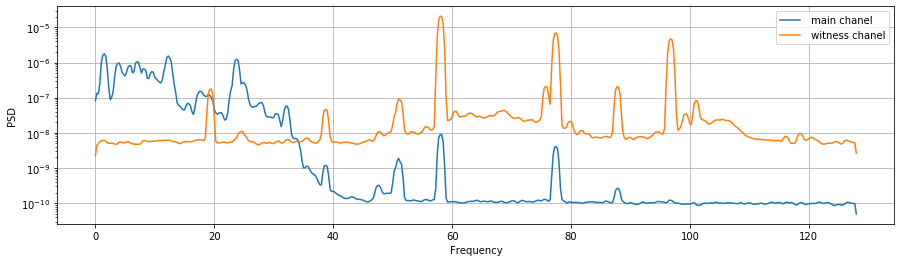

In [4]:
f1 , psdx = sig.welch(x,Sample_rate,'flattop',1024,scaling='spectrum')
f2 , psdy = sig.welch(y,Sample_rate,'flattop',1024,scaling='spectrum')
plt.figure(figsize=(15,4))
plt.semilogy(f1,psdx, label=r' main chanel')
plt.semilogy(f1,psdy, label=r' witness chanel')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.grid()
plt.legend()

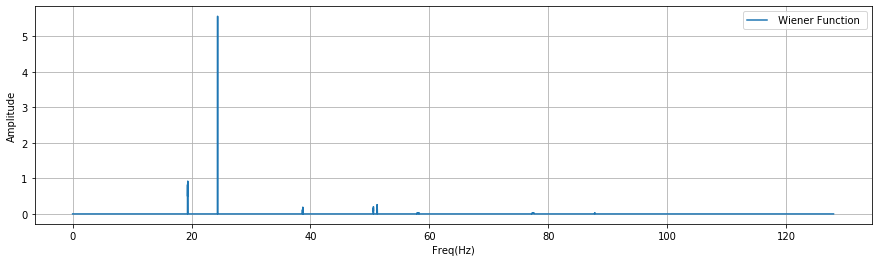

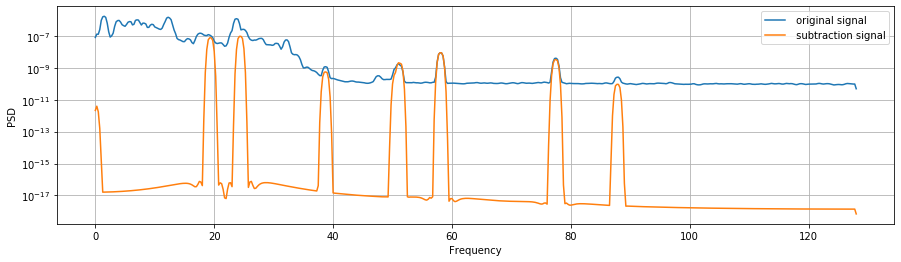

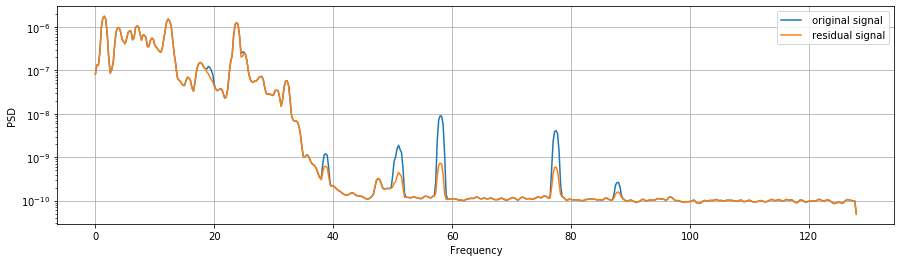

In [5]:
#Wiener filter
Seg_Wiener = 6
x_wiener = x[0:SegmentDuration*Sample_rate*Seg_Wiener]
y_wiener = y[0:SegmentDuration*Sample_rate*Seg_Wiener]

for i in range(Seg_Wiener):
    ind1 = i*SegmentDuration*Sample_rate
    ind2 = (i+1)*SegmentDuration*Sample_rate
    tmpx = x_wiener[ind1:ind2]
    tmpy = y_wiener[ind1:ind2]
    if i==0:
        T_f = np.fft.rfft(sig.hann(len(tmpx))*tmpx)/np.fft.rfft(sig.hann(len(tmpy))*tmpy)
    else:
        T_f += np.fft.rfft(sig.hann(len(tmpx))*tmpx)/np.fft.rfft(sig.hann(len(tmpy))*tmpy)
T_f = T_f/Seg_Wiener

freq = np.fft.rfftfreq(SegmentDuration*Sample_rate,d=1./Sample_rate)

#Coherence Cut
f ,cohsignal = sig.coherence(x_wiener,y_wiener,fs=Sample_rate,window='hann',nperseg=SegmentDuration*Sample_rate)
cohThreshold = 0.9
T_f[cohsignal < cohThreshold] = 0

#Plot Filter
plt.figure(figsize=(15,4))

#plt.subplot(121)
plt.plot(freq, np.abs(T_f), label=r' Wiener Function ')
plt.grid()
plt.xlabel('Freq(Hz)')
plt.ylabel('Amplitude')
#plt.xlim(0,20)
plt.legend()


tmp = np.fft.irfft(T_f)
tmp_len = len(tmp)
tmp = sig.hann(tmp_len)*np.roll(tmp, np.int(tmp_len/2))
tmp.resize(len(y)) # pad with zeros to lenght of witness
T_f_long = np.fft.rfft(np.roll(tmp,-np.int(tmp_len/2)))
T_f_interpolate = interpolate.interp1d(freq,T_f)
freq1 = np.fft.rfftfreq(len(y),d=1./Sample_rate)
T_f_long = T_f_interpolate(freq1)
tmp = np.fft.rfft(y)*T_f_long
est_subtract = np.fft.irfft(tmp)
res = x-est_subtract

f3 , psdx = sig.welch(x,Sample_rate,'flattop',1024,scaling='spectrum')
f4 , psdyO = sig.welch(est_subtract,Sample_rate,'flattop',1024,scaling='spectrum')
f5 , psdy1 = sig.welch(res,Sample_rate,'flattop',1024,scaling='spectrum')

plt.figure(figsize=(15,4))
plt.semilogy(f3,psdx, label=r' original signal')
plt.semilogy(f4,psdyO, label=r' subtraction signal')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.grid()
plt.legend()

plt.figure(figsize=(15,4))
plt.semilogy(f3,psdx, label=r' original signal')
plt.semilogy(f4,psdy1, label=r' residual signal')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.grid()
plt.legend()

Number of desired iteration:5


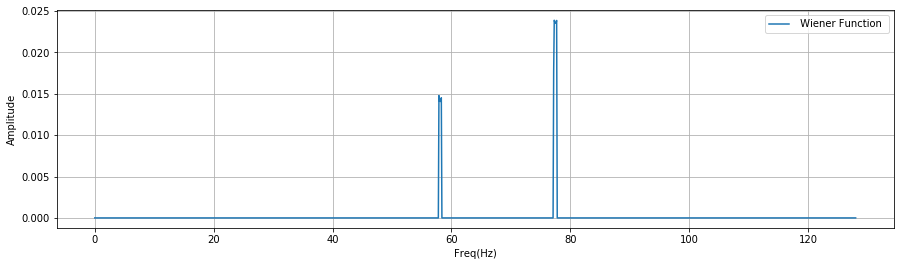

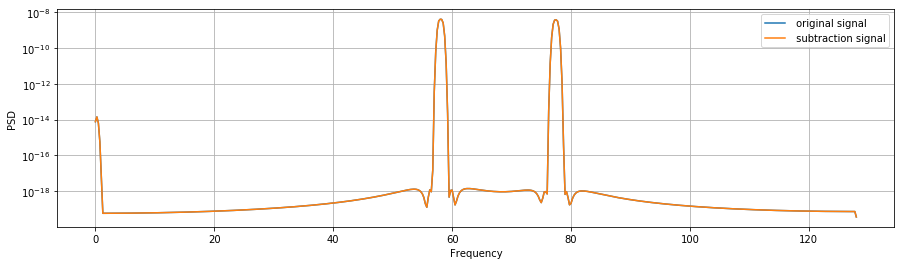

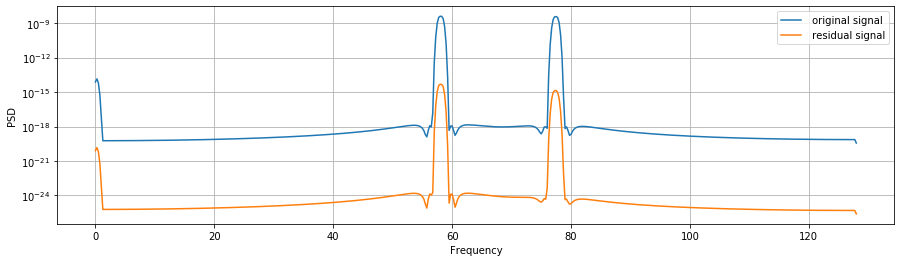

In [6]:
r =0
p = int(input("Number of desired iteration:"))
a = 0
Seg_Wiener = 6
while r<=p:
    
    for a in range(SegmentDuration):
        b = a + 10
        x_wiener = x[a:b*Sample_rate*Seg_Wiener]
        y_wiener = y[a:b*Sample_rate*Seg_Wiener]

        for i in range(Seg_Wiener):
            ind1 = i*(b-a)*Sample_rate
            ind2 = (i+1)*(b-a)*Sample_rate
            tmpx = x_wiener[ind1:ind2]
            tmpy = y_wiener[ind1:ind2]
            if i==0:
                T_f = np.fft.rfft(sig.hann(len(tmpx))*tmpx)/np.fft.rfft(sig.hann(len(tmpy))*tmpy)
            else:
                T_f += np.fft.rfft(sig.hann(len(tmpx))*tmpx)/np.fft.rfft(sig.hann(len(tmpy))*tmpy)
        T_f = T_f/Seg_Wiener

        freq = np.fft.rfftfreq((b-a)*Sample_rate,d=1./Sample_rate)

        #Coherence Cut
        f ,cohsignal = sig.coherence(x_wiener,y_wiener,fs=Sample_rate,window='hann',nperseg=(b-a)*Sample_rate)
        cohThreshold = 0.9
        T_f[cohsignal < cohThreshold] = 0



        tmp = np.fft.irfft(T_f)
        tmp_len = len(tmp)
        tmp = sig.hann(tmp_len)*np.roll(tmp, np.int(tmp_len/2))
        tmp.resize(len(y)) # pad with zeros to lenght of witness
        T_f_long = np.fft.rfft(np.roll(tmp,-np.int(tmp_len/2)))
        T_f_interpolate = interpolate.interp1d(freq,T_f)
        freq1 = np.fft.rfftfreq(len(y),d=1./Sample_rate)
        T_f_long = T_f_interpolate(freq1)
        tmp = np.fft.rfft(y)*T_f_long
        est_subtract = np.fft.irfft(tmp)
        res = x-est_subtract

        x = est_subtract
        a = b
    
    r = r+1
    
        

#Plot Filter
#Plot Filter
plt.figure(figsize=(15,4))

#plt.subplot(121)
plt.plot(freq, np.abs(T_f), label=r' Wiener Function ')
plt.grid()
plt.xlabel('Freq(Hz)')
plt.ylabel('Amplitude')
#plt.xlim(0,20)
plt.legend()

f3 , psdx = sig.welch(x,Sample_rate,'flattop',1024,scaling='spectrum')
f4 , psdyO = sig.welch(est_subtract,Sample_rate,'flattop',1024,scaling='spectrum')
f5 , psdy1 = sig.welch(res,Sample_rate,'flattop',1024,scaling='spectrum')

plt.figure(figsize=(15,4))
plt.semilogy(f3,psdx, label=r' original signal')
plt.semilogy(f4,psdyO, label=r' subtraction signal')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.grid()
plt.legend()

plt.figure(figsize=(15,4))
plt.semilogy(f3,psdx, label=r' original signal')
plt.semilogy(f4,psdy1, label=r' residual signal')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.grid()
plt.legend()